## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV



## Read in Data 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [2]:
# List files available
print(os.listdir("./input/"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [3]:
# Training data
app_train = pd.read_csv('./input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

# Exploratory Data Analysis


## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

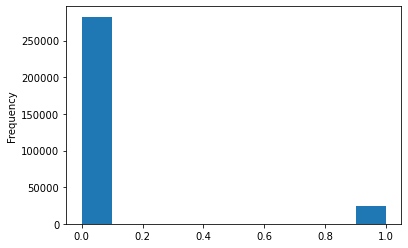

In [6]:
app_train['TARGET'].astype(int).plot.hist();

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Examine Missing Values

Next we can look at the number and percentage of missing values in each column. 

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). 

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [9]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Let's now look at the number of unique entries in each of the `object` (categorical) columns.

In [10]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)


In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [11]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [12]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)

print('Training Features shape: ', app_train.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [13]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:



In [14]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [15]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

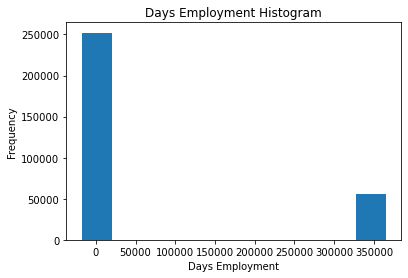

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [17]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.



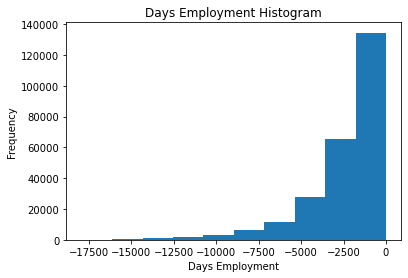

In [18]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers. 

### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [20]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [21]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

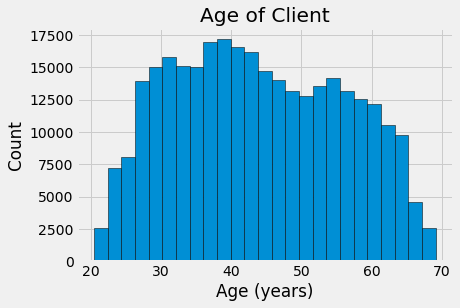

In [22]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

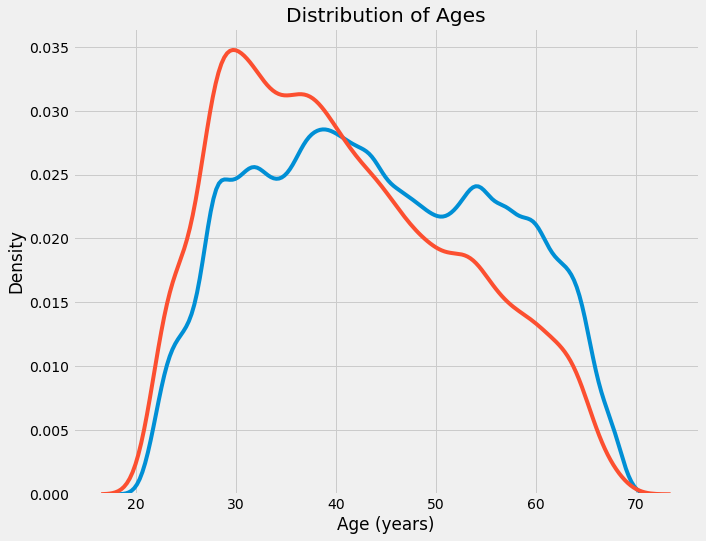

In [23]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [24]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [25]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

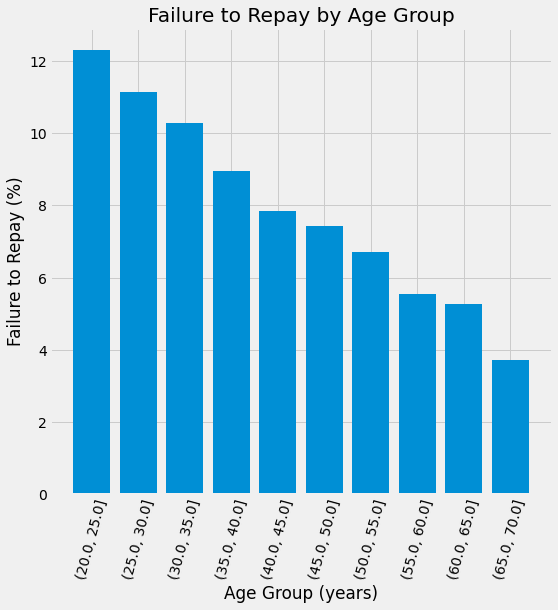

In [26]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

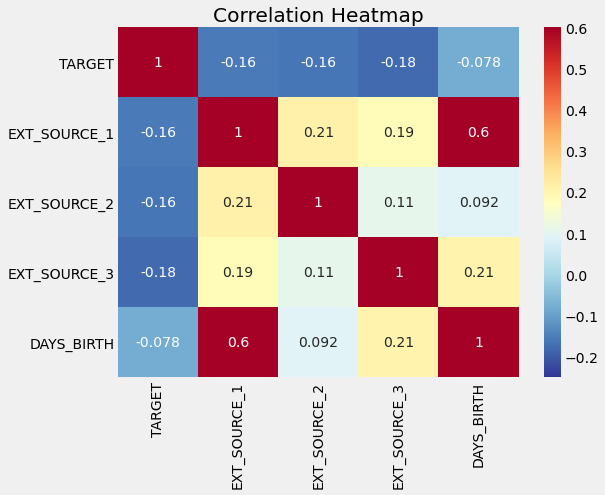

In [28]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

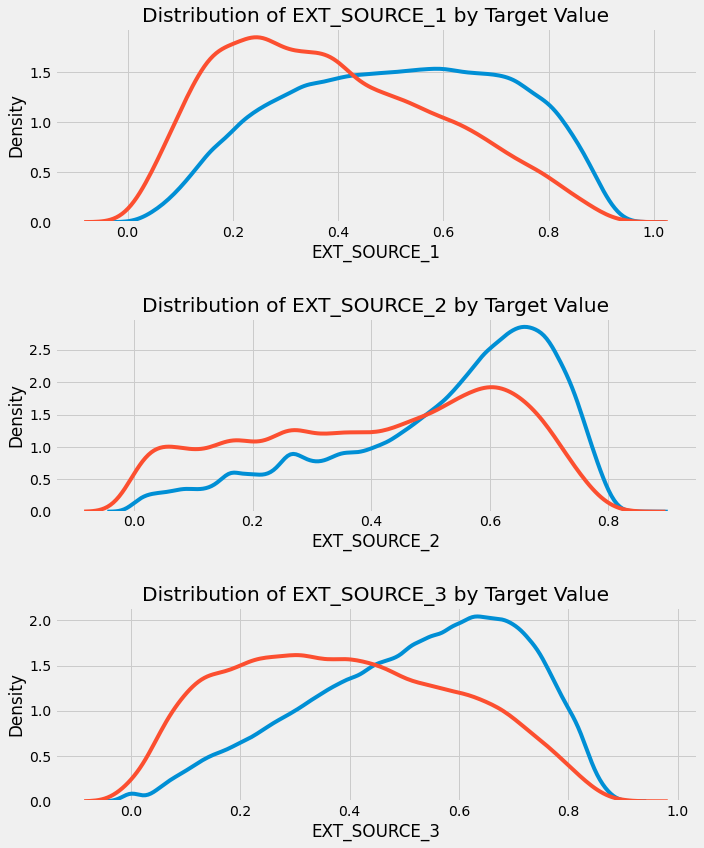

In [29]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pairs Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)! 

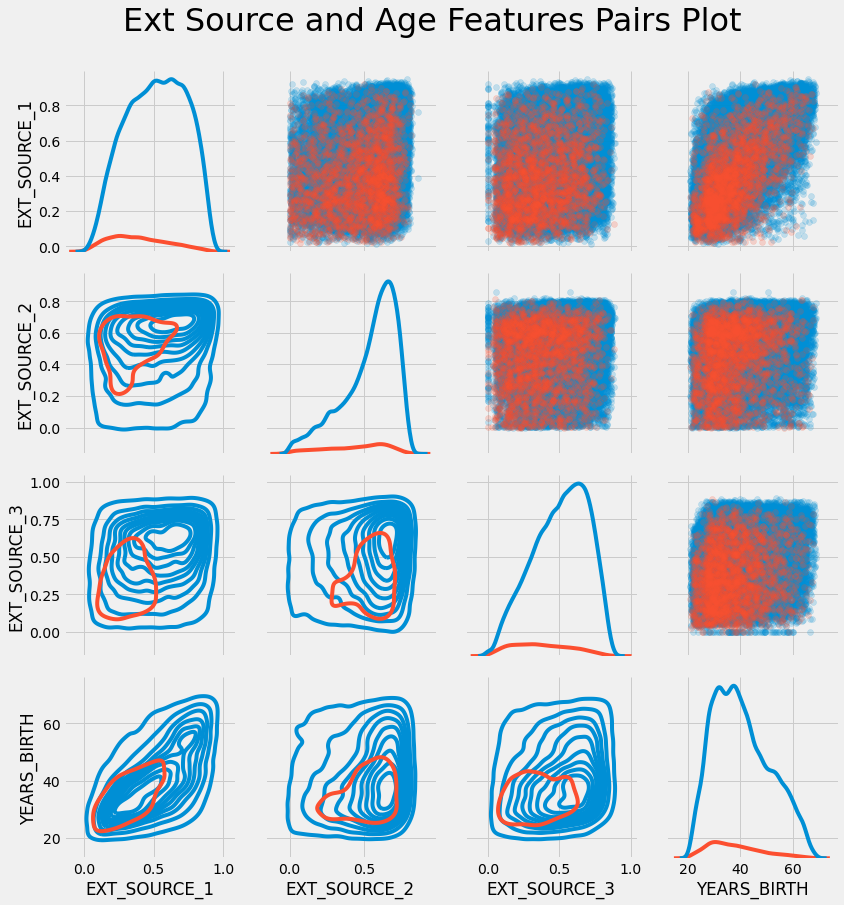

In [30]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client. 

# Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on [gradient boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. [This is a great article on the subject)](https://www.featurelabs.com/blog/secret-to-data-science-success/). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering." 

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some [automated tools](https://docs.featuretools.com/getting_started/install.html) to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods: 

* Polynomial features
* Domain knowledge features


## Polynomial Features

One simple feature construction method is called [polynomial features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1^2` and `EXT_SOURCE_2^2` and also variables such as `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x   `EXT_SOURCE_2^2`, and so on. These features that are a combination of multiple individual variables are called [interaction terms](https://en.wikipedia.org/wiki/Interaction_(statistics) because they  capture the interactions between variables. In other words, while two variables by themselves  may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. [Interaction terms are commonly used in statistical models](https://www.theanalysisfactor.com/interpreting-interactions-in-regression/) to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan. 

Jake VanderPlas writes about [polynomial features in his excellent book Python for Data Science](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html) for those who want more information.

In the following code, we create polynomial features using the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. [Scikit-Learn has a useful class called `PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into [problems with overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)). 

In [31]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')



poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [32]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [33]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [34]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn. 

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out! 

In [35]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)


Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [36]:
app_train_domain = app_train.copy()
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

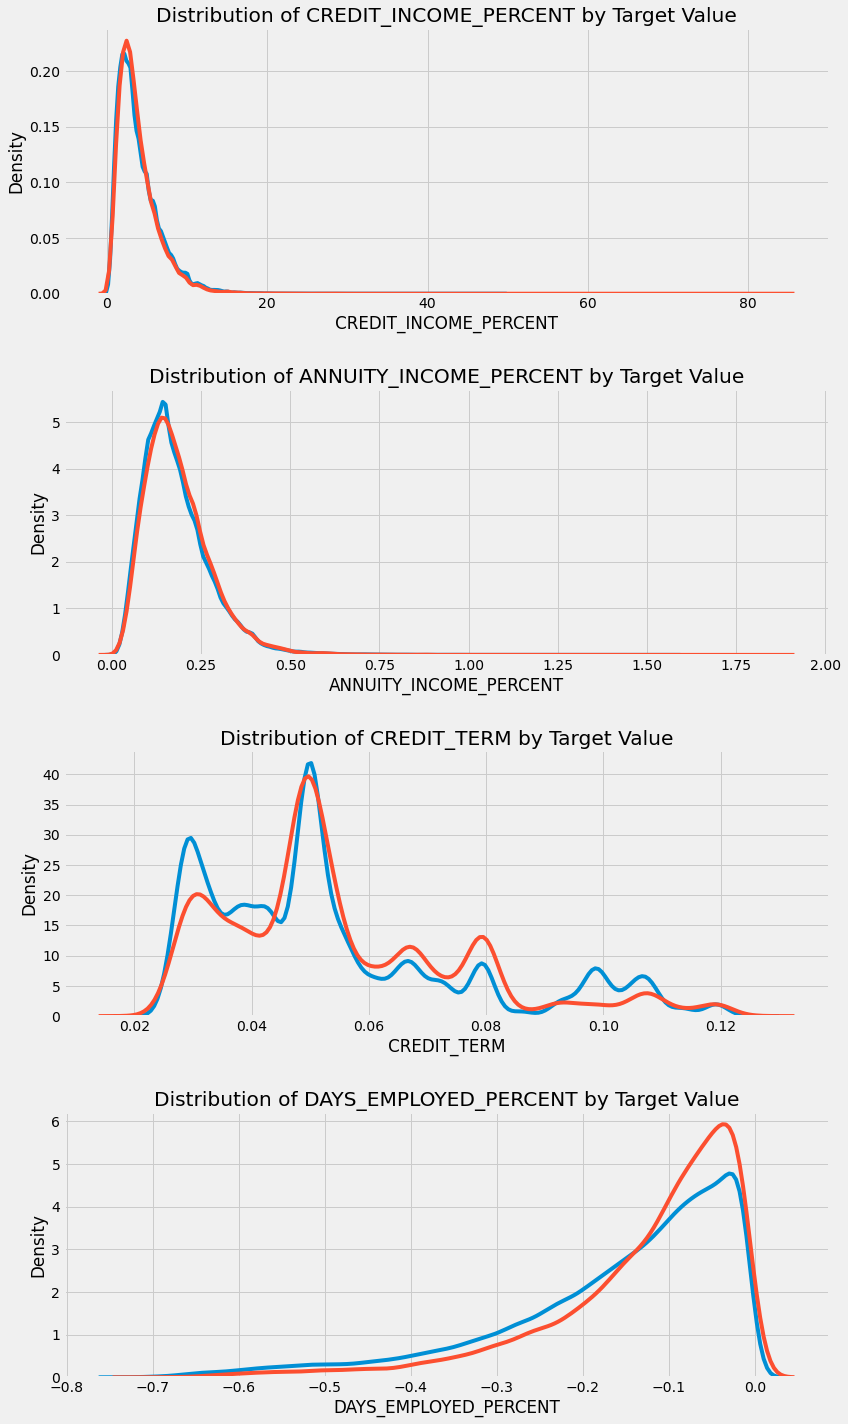

In [38]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

## - Creation de nouvelles variables:

En guise d'amélioration des performances, il y a création de nouvelles variables. Ces variables sont les suivantes: 

* `CREDIT_ANNUITY_RATIO`: le pourcentage du montant du crédit par rapport à la rente de prêt d'un client ( the percentage of the credit amount relative to a client's loan annuity).
* `CREDIT_GOODS_PRICE_RATIO`:  le pourcentage du montant du crédit par rapport au revenu d'un client (the percentage of the credit amount relative to a client's income).
* `CREDIT_DOWNPAYMENT`:  la durée du paiement en mois puisque la rente est le montant mensuel dû (the length of the payment in months since the annuity is the monthly amount due).
* `AGE_INT`: le rapport entre l'âge du client et le nombre de jours par an (the ratio of the client's age relative to the number of days by a year).

In [39]:
app_train['CREDIT_ANNUITY_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY']
app_train['CREDIT_GOODS_PRICE_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
app_train['CREDIT_DOWNPAYMENT'] = app_train['AMT_GOODS_PRICE'] / app_train['AMT_CREDIT']
app_train['AGE_INT'] =  (app_train['DAYS_BIRTH'] / (-365)).astype(int)

Il est intéressant par la suite de voir la corrélation avec `TARGET`. Les résultats de la corrélation  présentés ci-après; montrent que plusieurs des nouvelles variables ont une plus grande corrélation tq `CREDIT_ANNUITY_RATIO` et `CREDIT_GOODS_PRICE_RATIO` (en termes de grandeur absolue) avec la cible que les variables d'origine. 

Les racés KDE colorés par la valeur de TARGET, montrent une grande variation dans les valeurs de la TARGET avec `CREDIT_ANNUITY_RATIO` et `AGE_INT`.

Lorsque nous construisons des modèles d'apprentissage automatique, nous pouvons essayer avec et sans ces variables pour déterminer si elles aident réellement le modèle à apprendre.

Nous ajouterons ces variables aux données de training dans ce notebook, puis évaluerons les modèles avec (ce notebook) et sans (notebook initial). 

In [40]:
# Create a dataframe of the features 
new_poly_features = pd.DataFrame(app_train, 
                             columns = ['TARGET','CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_PRICE_RATIO', 
                                                                           'CREDIT_DOWNPAYMENT', 'AGE_INT'])

# Find the correlations with the target
poly_corrs = new_poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head())
print(poly_corrs.tail())

CREDIT_DOWNPAYMENT         -0.065407
CREDIT_ANNUITY_RATIO       -0.032102
CREDIT_GOODS_PRICE_RATIO    0.069427
AGE_INT                     0.078234
TARGET                      1.000000
Name: TARGET, dtype: float64
CREDIT_DOWNPAYMENT         -0.065407
CREDIT_ANNUITY_RATIO       -0.032102
CREDIT_GOODS_PRICE_RATIO    0.069427
AGE_INT                     0.078234
TARGET                      1.000000
Name: TARGET, dtype: float64


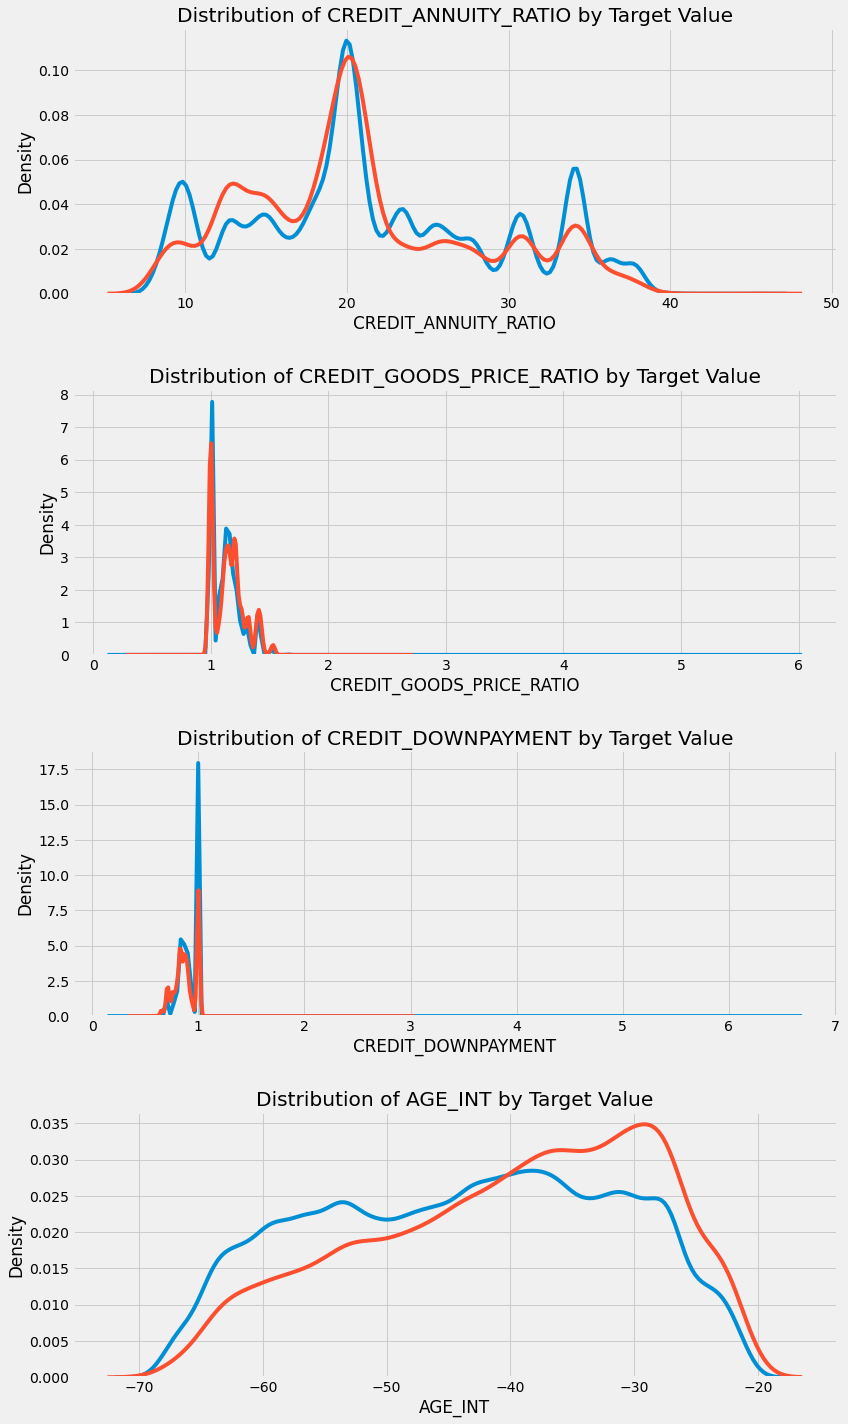

In [41]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_PRICE_RATIO', 'CREDIT_DOWNPAYMENT', 'AGE_INT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out! 

# Baseline

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition ([random guessing on a classification task will score a 0.5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

## Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective! 

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [42]:

# Si l'autre (A) marche supprimer celle ci

'''  Filling in the missing values (imputation). 
    The following code performs both of these preprocessing steps.
'''


from sklearn.impute import SimpleImputer 


# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
#test = app_test.copy()

# Median imputation of missing values
#imputer = Imputer(strategy = 'median')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
#test = imputer.transform(app_test)

#. Si l'autre marche (B) supprimer celle ci
''' Split in X and Y '''
# séparer le train et le test sets
X = train #X = app_train.drop(columns=["TARGET"]) 
y = app_train["TARGET"].values

## On crée un vecteur de prédiction à partir du vecteur de probabilités
#y_class=np.where(y>0.5, 1, 0)

#----> n'a aucune importance c'est soit 1 ou 0 n'a aucun effet c'est la même chose

##### Séparer les données en deux bases train/test.

In [45]:
'''Split the dataset in train and test.''' 

from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size=0.3 ) # 30% des données dans le jeu de test
#train,test = train_test_split(app_train,test_size=.3,random_state = 123)# 30% des données dans le jeu de test

print("train size:", len(X_train))
print("test size:", len(X_test))

train size: 215257
test size: 92254


In [46]:
'''standardiser les données d’entraînement et appliquer la même transformation aux données de test'''

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Apply MinMaxScaler (0, 1)   ----- Or .StandardScaler()
scaler = StandardScaler()

#scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print("X_train:", X_train.shape)
print('X_test: ', X_test.shape)

X_train: (215257, 244)
X_test:  (92254, 244)


We will use [`LogisticRegression`from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using `.fit` and then we make predictions on the testing data using `.predict_proba` (remember that we want probabilities and not a 0 or 1).

## Entraîner plusieurs modèles de classification : régression logistique, arbre de décision, random forests, xgboost/lightgbm

## Cross-validation avec GridSearchCV

In [47]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer, accuracy_score, recall_score, classification_report, auc , f1_score, precision_score, confusion_matrix, roc_auc_score

In [48]:
#Model function
def modelCV(algorithm, X_train, y_train, X_test, y_test, parameters):
    # Fixer les valeurs des hyperparamètres à tester
    #print(algorithm.get_params().keys())

    # Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
    score = ['accuracy', 'f1', 'recall', 'roc_auc']
    #score = ['f1_score','accuracy',  'precision', 'recall']


    # Créer un classifieur clf avec recherche d'hyperparamètre par validation croisée
    clf = model_selection.GridSearchCV(
    algorithm, # un classifieur kNN
    parameters,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    refit='f1', # the f1_score is being optimized the other just monitored
    return_train_score=True
    )
    
    # Train on the training data
    # Optimiser ce classifieur sur le jeu d'entraînement
    clf.fit(X_train, y_train)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)
    
    predictions = clf.predict(X_test) # ceci fonctionne bien pour tout sauf AUC
    # Pour AUC il faut rajouter un truc de probabilité.
    print (algorithm)
    
    acc = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    
    print ("Accuracy score : ", acc)
    print ("F1_Score score : ", f1)
    print ("Recall score   : ", recall)
    
    #  (3) ------> A remplacer par la matrice de confusion sur la base de test.    
    print ("classification report :\n",classification_report(y_test, predictions))
    print ("confusion matrix report :\n",confusion_matrix(y_test, predictions))
    tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[0,1]).ravel()

    print ("  tn: {0} fp: {1} , fn: {2} , tp: {3}: ".format(tn, fp, fn, tp) )
    # metrics.confusion_matrix(y_true, y_pred)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
 
    # predict the probabilities of not paying a loan
    prediction_probabilities = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test , prediction_probabilities)
    print ("AUC   : ", auc)
    return (acc, f1, recall, auc, clf.best_params_ , fn, fp)


    

In [49]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit_parameters = { 'C':[ 1e-3,1e-2,0.1, 1, 10]}

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc_parameters = {
    "n_estimators": [10, 30, 50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 20],
    #"min_samples_leaf": [50, 100, 200]    
}


from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc_parameters = {
    'criterion':['gini','entropy'],
    'max_depth': np.arange(3, 15)   
}


from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_parameters = {
     # Parameters that we are going to tune.
    #'max_depth':[3, 5, 7],
    #'min_child_weight':[1, 3, 5]
    'max_depth':[3, 4, 5],
    'min_child_weight':[1, 3, 5]
}

from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm_parameters = {
    "n_estimators": [50, 75, 100],
    "boosting_type": ["gbdt", "dart", "goss"],
    "max_depth": [1, 2, 5] 
}

from sklearn.utils.class_weight import compute_class_weight

### - Logistic Regression

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 0.001}
LogisticRegression()
Accuracy score :  0.9192988921889566
F1_Score score :  0.018716225121919068
Recall score   :  0.00953532097770615
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.50      0.01      0.02      7446

    accuracy                           0.92     92254
   macro avg       0.71      0.50      0.49     92254
weighted avg       0.89      0.92      0.88     92254

confusion matrix report :
 [[84738    70]
 [ 7375    71]]
  tn: 84738 fp: 70 , fn: 7375 , tp: 71: 


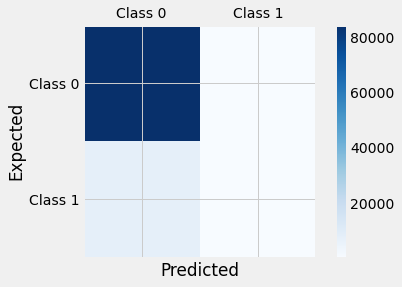

AUC   :  0.7519344623552889


In [50]:
acc_11, f1_11, recall_11, auc_11, best_params_11, fn_11, fp_11 = modelCV(logit,X_train, y_train,X_test,y_test,logit_parameters)

## - Random Forest Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 50}
RandomForestClassifier()
Accuracy score :  0.9193205714657359
F1_Score score :  0.0010736813850489866
Recall score   :  0.0005372011818426001
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.80      0.00      0.00      7446

    accuracy                           0.92     92254
   macro avg       0.86      0.50      0.48     92254
weighted avg       0.91      0.92      0.88     92254

confusion matrix report :
 [[84807     1]
 [ 7442     4]]
  tn: 84807 fp: 1 , fn: 7442 , tp: 4: 


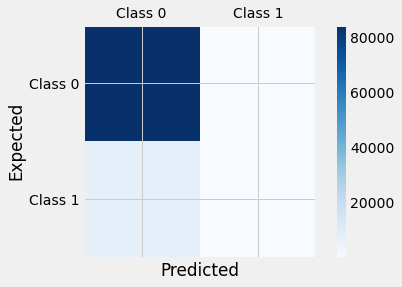

AUC   :  0.7224810574000299


In [53]:
acc_21, f1_21, recall_21, auc_21, best_params_21 , fn_21, fp_21 = modelCV(rfc,X_train, y_train,X_test,y_test,rfc_parameters)

## - Decision Tree Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'criterion': 'gini', 'max_depth': 3}
DecisionTreeClassifier()
Accuracy score :  0.9192880525505669
F1_Score score :  0.0
Recall score   :  0.0
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.00      0.00      0.00      7446

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

confusion matrix report :
 [[84808     0]
 [ 7446     0]]
  tn: 84808 fp: 0 , fn: 7446 , tp: 0: 


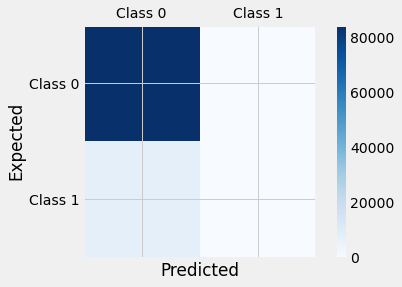

AUC   :  0.6860612743546131


In [54]:
acc_31, f1_31, recall_31, auc_31, best_params_31 , fn_31, fp_31 = modelCV(dtc,X_train, y_train,X_test,y_test,dtc_parameters)

## - XGBoost Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 4, 'min_child_weight': 3}
XGBClassifier()
Accuracy score :  0.9195373642335292
F1_Score score :  0.020324666754652238
Recall score   :  0.010341122750470052
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.59      0.01      0.02      7446

    accuracy                           0.92     92254
   macro avg       0.75      0.50      0.49     92254
weighted avg       0.89      0.92      0.88     92254

confusion matrix report :
 [[84754    54]
 [ 7369    77]]
  tn: 84754 fp: 54 , fn: 7369 , tp: 77: 


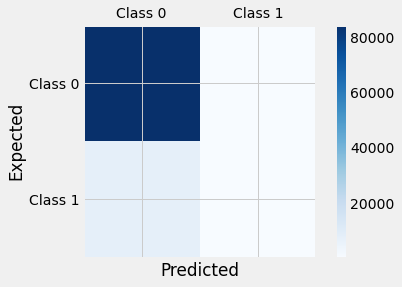

AUC   :  0.7634998155635457


In [106]:
acc_41, f1_41, recall_41, auc_41, best_params_41 , fn_41, fp_41 = modelCV(xgb,X_train, y_train,X_test,y_test,xgb_parameters)

### - Light GBM classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'boosting_type': 'gbdt', 'max_depth': 5, 'n_estimators': 100}
LGBMClassifier()
Accuracy score :  0.9196240813406464
F1_Score score :  0.031098915457990324
Recall score   :  0.01598173515981735
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.57      0.02      0.03      7446

    accuracy                           0.92     92254
   macro avg       0.75      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254

confusion matrix report :
 [[84720    88]
 [ 7327   119]]
  tn: 84720 fp: 88 , fn: 7327 , tp: 119: 


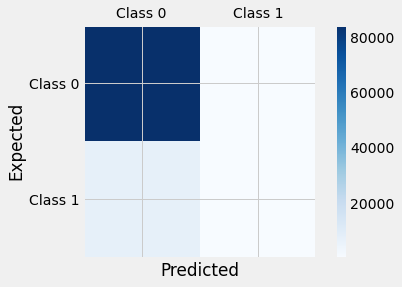

AUC   :  0.7655256766430466


In [56]:
acc_51, f1_51, recall_51, auc_51, best_params_51 , fn_51, fp_51 = modelCV(lgbm,X_train, y_train,X_test,y_test,lgbm_parameters)
## Apprenants faibles

## Métrique métier (provisoire)


min {metric_metier} = max { - FP - 10 * FN }

In [57]:
#. from definition on stackoverflow  (clipped_r2(y_true, y_pred))
# y_test = y_true  ;  y_pred = predictions

def my_custom_metrique_provisoire (y_test, predictions):    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[0,1]).ravel()  
    metric_metier = -fp - 10 * fn
    return metric_metier
# ---> sur le modele valeur predict de l'algo et la valeur réelle.

In [58]:
# utilisation du nouveau scorer qui augmente le recall et diminue le False Negative
# utilisation du nouveau scorer qui augmente le gain d'intérêt et diminue les pertes d'intérêt et de crédit
my_scorer = make_scorer(my_custom_metrique_provisoire, greater_is_better=True)

In [59]:
#Model function utilisant la métrique métier
def modelCVmetrique(algorithm, X_train, y_train, X_test, y_test, parameters):
    # Créer un classifieur clf avec recherche d'hyperparamètre par validation croisée
    clf = model_selection.GridSearchCV(
    algorithm, # un classifieur
    parameters,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée   
    scoring=my_scorer,  # nouveau scorer personnalisé
    )
    
    
    # Calculer la valeur de la base de test
    
    # Train on the training data
    # Optimiser ce classifieur sur le jeu d'entraînement
    clf.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)

    predictions = clf.predict(X_test) # ceci fonctionne bien pour tout sauf AUC
    # Pour AUC il faut rajouter un truc de probabilité.
    print (algorithm)
    
    acc = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    
    print ("Accuracy score : ", acc)
    print ("F1_Score score : ", f1)
    print ("Recall score   : ", recall)
    # Customized Scorer
    metric_metier = my_custom_metrique_provisoire (y_test, predictions)
    print ("Customized scorer : ", metric_metier)
    
    
    
    #  (3) ------> A remplacer par la matrice de confusion sur la base de test.    
    print ("classification report :\n",classification_report(y_test, predictions))
    print ("confusion matrix report :\n",confusion_matrix(y_test, predictions))
    tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[0,1]).ravel()

    print ("  tn: {0} fp: {1} , fn: {2} , tp: {3}: ".format(tn, fp, fn, tp) )
    # metrics.confusion_matrix(y_true, y_pred)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
 
    # predict the probabilities of not paying a loan
    prediction_probabilities = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test , prediction_probabilities)
    print ("AUC   : ", auc)
    return (acc, f1, recall, auc, clf.best_params_ , metric_metier, fn, fp)


### - Logistic Regression

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 1}
LogisticRegression()
Accuracy score :  0.919157976889891
F1_Score score :  0.024843096234309626
Recall score   :  0.012758528068761751
Customized scorer :  -73617
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.47      0.01      0.02      7446

    accuracy                           0.92     92254
   macro avg       0.70      0.51      0.49     92254
weighted avg       0.88      0.92      0.88     92254

confusion matrix report :
 [[84701   107]
 [ 7351    95]]
  tn: 84701 fp: 107 , fn: 7351 , tp: 95: 


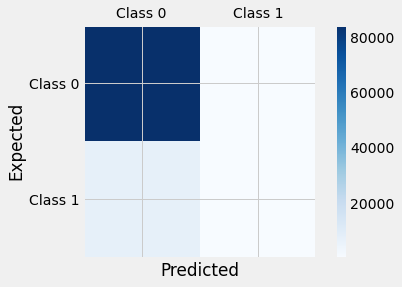

AUC   :  0.7514846922367031


In [60]:
acc_12, f1_12, recall_12, auc_12, best_params_12 , metric_metier_12, fn_12, fp_12 = modelCVmetrique(logit,X_train, y_train,X_test,y_test,logit_parameters)

In [61]:
print("acc_12 :{0}, f1_12: {1}, recall_12: {2}, auc_12: {3}, best_params_12: {4} , metric_metier_12: {5}, fn_12: {6}, fp_12: {7}".format(acc_12, f1_12, recall_12, auc_12, best_params_12 , metric_metier_12, fn_12, fp_12))

acc_12 :0.919157976889891, f1_12: 0.024843096234309626, recall_12: 0.012758528068761751, auc_12: 0.7514846922367031, best_params_12: {'C': 1} , metric_metier_12: -73617, fn_12: 7351, fp_12: 107


- Gestion du problème du déséquilibre des classes :  
(1) Reformuler le jeu d'apprentissage tq:  (a) moins de clients majoritaires. (b) plus de clients minoritaires {smot, imblearn}  
(2) Pondération : classweight

### - Random Forest Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 10}
RandomForestClassifier()
Accuracy score :  0.9190604201443839
F1_Score score :  0.013997094942559093
Recall score   :  0.007117915659414451
Customized scorer :  -74004
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.42      0.01      0.01      7446

    accuracy                           0.92     92254
   macro avg       0.67      0.50      0.49     92254
weighted avg       0.88      0.92      0.88     92254

confusion matrix report :
 [[84734    74]
 [ 7393    53]]
  tn: 84734 fp: 74 , fn: 7393 , tp: 53: 


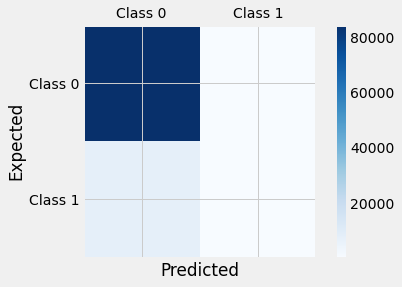

AUC   :  0.6797558732657227


In [62]:
acc_22, f1_22, recall_22, auc_22, best_params_22 , metric_metier_22, fn_22, fp_22 = modelCVmetrique(rfc,X_train, y_train,X_test,y_test,rfc_parameters)


### - Decision Tree Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'criterion': 'gini', 'max_depth': 14}
DecisionTreeClassifier()
Accuracy score :  0.9086110087367485
F1_Score score :  0.09412270334157086
Recall score   :  0.058823529411764705
Customized scorer :  -71503
classification report :
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     84808
           1       0.24      0.06      0.09      7446

    accuracy                           0.91     92254
   macro avg       0.58      0.52      0.52     92254
weighted avg       0.87      0.91      0.88     92254

confusion matrix report :
 [[83385  1423]
 [ 7008   438]]
  tn: 83385 fp: 1423 , fn: 7008 , tp: 438: 


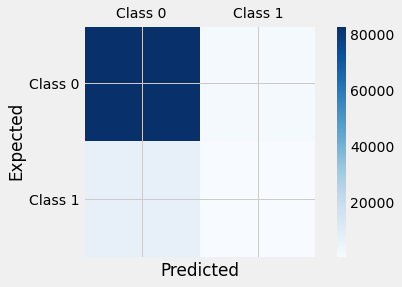

AUC   :  0.6752267973911107


In [63]:
#modelCVmetrique(dtc,X_train, y_train,X_test,y_test,parameters)
acc_32, f1_32, recall_32, auc_32, best_params_32 , metric_metier_32, fn_32, fp_32 = modelCVmetrique(dtc,X_train, y_train,X_test,y_test,dtc_parameters)



### - XG Boost

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 5, 'min_child_weight': 1}
XGBClassifier()
Accuracy score :  0.9195698831486981
F1_Score score :  0.029049986914420317
Recall score   :  0.014907332796132152
Customized scorer :  -73435
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.57      0.01      0.03      7446

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254

confusion matrix report :
 [[84723    85]
 [ 7335   111]]
  tn: 84723 fp: 85 , fn: 7335 , tp: 111: 


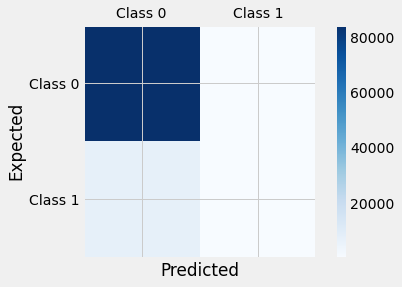

AUC   :  0.7653101172893471


In [107]:
#modelCV(xgb,X_train, y_train,X_test,y_test,parameters)
acc_42, f1_42, recall_42, auc_42, best_params_42 , metric_metier_42, fn_42, fp_42 = modelCVmetrique(xgb,X_train, y_train,X_test,y_test,xgb_parameters)

### - LightGmb Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'boosting_type': 'gbdt', 'max_depth': 5, 'n_estimators': 100}
LGBMClassifier()
Accuracy score :  0.9196240813406464
F1_Score score :  0.031098915457990324
Recall score   :  0.01598173515981735
Customized scorer :  -73358
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.57      0.02      0.03      7446

    accuracy                           0.92     92254
   macro avg       0.75      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254

confusion matrix report :
 [[84720    88]
 [ 7327   119]]
  tn: 84720 fp: 88 , fn: 7327 , tp: 119: 


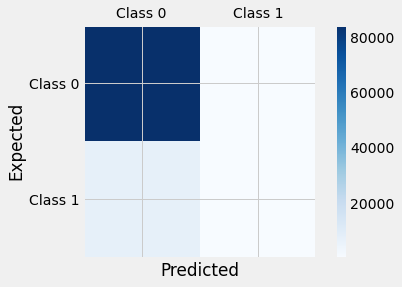

AUC   :  0.7655256766430466


In [65]:
#modelCV(lgbm,X_train, y_train,X_test,y_test,parameters)
acc_52, f1_52, recall_52, auc_52, best_params_52 , metric_metier_52, fn_52, fp_52 = modelCVmetrique(lgbm,X_train, y_train,X_test,y_test,lgbm_parameters)

## - Classweight : Pondération

### - LogisticRegression

In [66]:
logit_cw = LogisticRegression(solver="liblinear", class_weight="balanced")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 0.1}
LogisticRegression(class_weight='balanced', solver='liblinear')
Accuracy score :  0.6907017581893468
F1_Score score :  0.2623823803122738
Recall score   :  0.6815739994627988
Customized scorer :  -49873
classification report :
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     84808
           1       0.16      0.68      0.26      7446

    accuracy                           0.69     92254
   macro avg       0.56      0.69      0.53     92254
weighted avg       0.90      0.69      0.76     92254

confusion matrix report :
 [[58645 26163]
 [ 2371  5075]]
  tn: 58645 fp: 26163 , fn: 2371 , tp: 5075: 


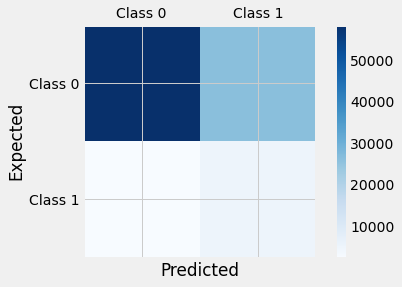

AUC   :  0.7513738827744523


In [67]:
acc_13, f1_13, recall_13, auc_13, best_params_13 , metric_metier_13, fn_13, fp_13 = modelCVmetrique(logit_cw,X_train, y_train,X_test,y_test,logit_parameters)

### - Random Forest Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
RandomForestClassifier(class_weight='balanced')
Accuracy score :  0.7272096602857329
F1_Score score :  0.26877033937703393
Recall score   :  0.6211388665055063
Customized scorer :  -50555
classification report :
               precision    recall  f1-score   support

           0       0.96      0.74      0.83     84808
           1       0.17      0.62      0.27      7446

    accuracy                           0.73     92254
   macro avg       0.56      0.68      0.55     92254
weighted avg       0.89      0.73      0.79     92254

confusion matrix report :
 [[62463 22345]
 [ 2821  4625]]
  tn: 62463 fp: 22345 , fn: 2821 , tp: 4625: 


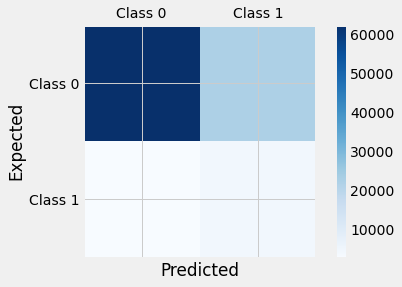

AUC   :  0.7409164064463837


In [69]:
rfc_cw = RandomForestClassifier(class_weight="balanced")
acc_23, f1_23, recall_23, auc_23, best_params_23 , metric_metier_23, fn_23, fp_23 = modelCVmetrique(rfc_cw,X_train, y_train,X_test,y_test,rfc_parameters)

### - Decision Tree Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'criterion': 'entropy', 'max_depth': 7}
DecisionTreeClassifier(class_weight='balanced')
Accuracy score :  0.6876341405250721
F1_Score score :  0.247027775600324
Recall score   :  0.6348374966424926
Customized scorer :  -53288
classification report :
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     84808
           1       0.15      0.63      0.25      7446

    accuracy                           0.69     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.69      0.76     92254

confusion matrix report :
 [[58710 26098]
 [ 2719  4727]]
  tn: 58710 fp: 26098 , fn: 2719 , tp: 4727: 


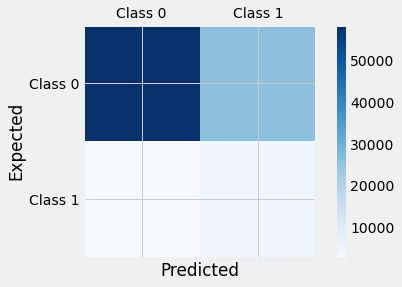

AUC   :  0.714890129410959


In [70]:
dtc_cw = DecisionTreeClassifier(class_weight="balanced")
acc_33, f1_33, recall_33, auc_33, best_params_33 , metric_metier_33, fn_33, fp_33 = modelCVmetrique(dtc_cw,X_train, y_train,X_test,y_test,dtc_parameters)

### - XG Boost

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 5, 'min_child_weight': 1}
XGBClassifier(class_weight='balanced')
Accuracy score :  0.9195698831486981
F1_Score score :  0.029049986914420317
Recall score   :  0.014907332796132152
Customized scorer :  -73435
classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84808
           1       0.57      0.01      0.03      7446

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254

confusion matrix report :
 [[84723    85]
 [ 7335   111]]
  tn: 84723 fp: 85 , fn: 7335 , tp: 111: 


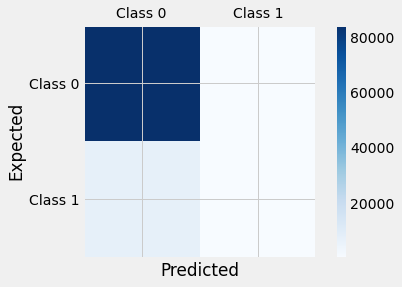

AUC   :  0.7653101172893471


In [108]:
xgb_cw = XGBClassifier(class_weight="balanced")
acc_43, f1_43, recall_43, auc_43, best_params_43 , metric_metier_43, fn_43, fp_43 = modelCVmetrique(xgb_cw,X_train, y_train,X_test,y_test,xgb_parameters)

### - LightGmb Classifier

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'boosting_type': 'gbdt', 'max_depth': 5, 'n_estimators': 100}
LGBMClassifier(class_weight='balanced')
Accuracy score :  0.7097578424783749
F1_Score score :  0.2731418643791737
Recall score   :  0.6756647864625303
Customized scorer :  -48511
classification report :
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     84808
           1       0.17      0.68      0.27      7446

    accuracy                           0.71     92254
   macro avg       0.57      0.69      0.55     92254
weighted avg       0.90      0.71      0.77     92254

confusion matrix report :
 [[60447 24361]
 [ 2415  5031]]
  tn: 60447 fp: 24361 , fn: 2415 , tp: 5031: 


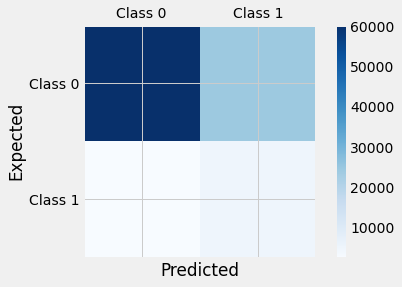

AUC   :  0.7637853010816007


In [72]:
lgbm_cw = LGBMClassifier(class_weight="balanced") 
#modelCV(lgbm,X_train, y_train,X_test,y_test,parameters)
acc_53, f1_53, recall_53, auc_53, best_params_53 , metric_metier_53, fn_53, fp_53 = modelCVmetrique(lgbm_cw,X_train, y_train,X_test,y_test,lgbm_parameters)

### - Tableau récapitulatif des performances

In [130]:
metric_metier_11=metric_metier_21=metric_metier_31=metric_metier_41=metric_metier_51=0
models = pd.DataFrame({
    'Model': ['Logistic Regression','Logistic Regression','Logistic Regression', 'Random Forest', 'Random Forest', 'Random Forest', 'Decision Tree', 'Decision Tree','Decision Tree','XG Boost','XG Boost','XG Boost', 'Light GMB', 'Light GMB', 'Light GMB'],
    'Optimisation' : ['Aucune','Metrique métier','Pondération','Aucune','Metrique métier','Pondération','Aucune','Metrique métier','Pondération','Aucune','Metrique métier','Pondération','Aucune','Metrique métier','Pondération'],
    'Accuracy Score': [acc_11,acc_12,acc_13,acc_21,acc_22,acc_23,acc_31,acc_32,acc_33  ,acc_41,acc_42,acc_43  ,acc_51,acc_52,acc_53],
    'F1 Score' : [f1_11,f1_12,f1_13,f1_21,f1_22,f1_23,f1_31,f1_32,f1_33 ,f1_41,f1_42,f1_43  ,f1_51,f1_52,f1_53],
    'Recall Score' : [recall_11,recall_12,recall_13,recall_21,recall_22,recall_23,recall_31,recall_32,recall_33, recall_41,recall_42,recall_43 ,recall_51,recall_52,recall_53],
    'AUC Score' : [auc_11,auc_12,auc_13,auc_21,auc_22,auc_23,auc_31,auc_32,auc_33  ,auc_41,auc_42,auc_43 ,auc_51,auc_52,auc_53],
    'Paramètres' : [best_params_11,best_params_12, best_params_13,best_params_21,best_params_22,best_params_23,best_params_31,best_params_32,best_params_33 ,best_params_41,best_params_42,best_params_43  ,best_params_51,best_params_52,best_params_53],
    'Metrique métier' : [metric_metier_11,metric_metier_12,metric_metier_13,metric_metier_21,metric_metier_22,metric_metier_23,metric_metier_31,metric_metier_32,metric_metier_33  ,metric_metier_41,metric_metier_42,metric_metier_43   ,metric_metier_51,metric_metier_52,metric_metier_53],
    'fn' : [fn_11,fn_12,fn_13,fn_21,fn_22,fn_23,fn_31,fn_32,fn_33 ,fn_41,fn_42,fn_43  ,fn_51,fn_52,fn_53],
    'fp' : [fp_11,fp_12,fp_13,fp_21,fp_22,fp_23,fp_31,fp_32,fp_33 ,fp_41,fp_42,fp_43  ,fp_51,fp_52,fp_53]
})
models

Model     Optimisation  Accuracy Score  F1 Score  \
0   Logistic Regression           Aucune        0.919299  0.018716   
1   Logistic Regression  Metrique métier        0.919158  0.024843   
2   Logistic Regression      Pondération        0.690702  0.262382   
3         Random Forest           Aucune        0.919321  0.001074   
4         Random Forest  Metrique métier        0.919060  0.013997   
5         Random Forest      Pondération        0.727210  0.268770   
6         Decision Tree           Aucune        0.919288  0.000000   
7         Decision Tree  Metrique métier        0.908611  0.094123   
8         Decision Tree      Pondération        0.687634  0.247028   
9              XG Boost           Aucune        0.919537  0.020325   
10             XG Boost  Metrique métier        0.919570  0.029050   
11             XG Boost      Pondération        0.919570  0.029050   
12            Light GMB           Aucune        0.919624  0.031099   
13            Light GMB  Metrique métier        0.919624  0.031099   
14            Light GMB      Pondération        0.709758  0.273142   

    Recall Score  AUC Score  \
0       0.009535   0.751934   
1       0.012759   0.751485   
2       0.681574   0.751374   
3       0.000537   0.722481   
4       0.007118   0.679756   
5       0.621139   0.740916   
6       0.000000   0.686061   
7       0.058824   0.675227   
8       0.634837   0.714890   
9       0.010341   0.763500   
10      0.014907   0.765310   
11      0.014907   0.765310   
12      0.015982   0.765526   
13      0.015982   0.765526   
14      0.675665   0.763785   

                                           Paramètres  Metrique métier    fn  \
0                                        {'C': 0.001}                0  7375   
1                                            {'C': 1}           -73617  7351   
2                                          {'C': 0.1}           -49873  2371   
3   {'criterion': 'gini', 'max_depth': 20, 'n_esti...                0  7442   
4   {'criterion': 'gini', 'max_depth': 20, 'n_esti...           -74004  7393   
5   {'criterion': 'entropy', 'max_depth': 10, 'n_e...           -50555  2821   
6               {'criterion': 'gini', 'max_depth': 3}                0  7446   
7              {'criterion': 'gini', 'max_depth': 14}           -71503  7008   
8            {'criterion': 'entropy', 'max_depth': 7}           -53288  2719   
9             {'max_depth': 4, 'min_child_weight': 3}                0  7369   
10            {'max_depth': 5, 'min_child_weight': 1}           -73435  7335   
11            {'max_depth': 5, 'min_child_weight': 1}           -73435  7335   
12  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...                0  7327   
13  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...           -73358  7327   
14  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...           -48511  2415   

       fp  
0      70  
1     107  
2   26163  
3       1  
4      74  
5   22345  
6       0  
7    1423  
8   26098  
9      54  
10     85  
11     85  
12     88  
13     88  
14  24361

In [131]:
models.to_csv("models_vars_pertes.csv",sep="\t", index=False)

In [116]:
models[ models.Optimisation=='Aucune'].sort_values(['Recall Score'], ascending=False)

Model Optimisation  Accuracy Score  F1 Score  Recall Score  \
12            Light GMB       Aucune        0.919624  0.031099      0.015982   
9              XG Boost       Aucune        0.919537  0.020325      0.010341   
0   Logistic Regression       Aucune        0.919299  0.018716      0.009535   
3         Random Forest       Aucune        0.919321  0.001074      0.000537   
6         Decision Tree       Aucune        0.919288  0.000000      0.000000   

    AUC Score                                         Paramètres  \
12   0.765526  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...   
9    0.763500            {'max_depth': 4, 'min_child_weight': 3}   
0    0.751934                                       {'C': 0.001}   
3    0.722481  {'criterion': 'gini', 'max_depth': 20, 'n_esti...   
6    0.686061              {'criterion': 'gini', 'max_depth': 3}   

    Metrique métier    fn  fp  
12                0  7327  88  
9                 0  7369  54  
0                 0  7375  70  
3                 0  7442   1  
6                 0  7446   0

In [113]:
models.sort_values(['F1 Score'], ascending=False)

Model     Optimisation  Accuracy Score  F1 Score  \
14            Light GMB      Pondération        0.709758  0.273142   
5         Random Forest      Pondération        0.727210  0.268770   
2   Logistic Regression      Pondération        0.690702  0.262382   
8         Decision Tree      Pondération        0.687634  0.247028   
7         Decision Tree  Metrique métier        0.908611  0.094123   
12            Light GMB           Aucune        0.919624  0.031099   
13            Light GMB  Metrique métier        0.919624  0.031099   
10             XG Boost  Metrique métier        0.919570  0.029050   
11             XG Boost      Pondération        0.919570  0.029050   
1   Logistic Regression  Metrique métier        0.919158  0.024843   
9              XG Boost           Aucune        0.919537  0.020325   
0   Logistic Regression           Aucune        0.919299  0.018716   
4         Random Forest  Metrique métier        0.919060  0.013997   
3         Random Forest           Aucune        0.919321  0.001074   
6         Decision Tree           Aucune        0.919288  0.000000   

    Recall Score  AUC Score  \
14      0.675665   0.763785   
5       0.621139   0.740916   
2       0.681574   0.751374   
8       0.634837   0.714890   
7       0.058824   0.675227   
12      0.015982   0.765526   
13      0.015982   0.765526   
10      0.014907   0.765310   
11      0.014907   0.765310   
1       0.012759   0.751485   
9       0.010341   0.763500   
0       0.009535   0.751934   
4       0.007118   0.679756   
3       0.000537   0.722481   
6       0.000000   0.686061   

                                           Paramètres  Metrique métier    fn  \
14  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...           -48511  2415   
5   {'criterion': 'entropy', 'max_depth': 10, 'n_e...           -50555  2821   
2                                          {'C': 0.1}           -49873  2371   
8            {'criterion': 'entropy', 'max_depth': 7}           -53288  2719   
7              {'criterion': 'gini', 'max_depth': 14}           -71503  7008   
12  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...                0  7327   
13  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...           -73358  7327   
10            {'max_depth': 5, 'min_child_weight': 1}           -73435  7335   
11            {'max_depth': 5, 'min_child_weight': 1}           -73435  7335   
1                                            {'C': 1}           -73617  7351   
9             {'max_depth': 4, 'min_child_weight': 3}                0  7369   
0                                        {'C': 0.001}                0  7375   
4   {'criterion': 'gini', 'max_depth': 20, 'n_esti...           -74004  7393   
3   {'criterion': 'gini', 'max_depth': 20, 'n_esti...                0  7442   
6               {'criterion': 'gini', 'max_depth': 3}                0  7446   

       fp  
14  24361  
5   22345  
2   26163  
8   26098  
7    1423  
12     88  
13     88  
10     85  
11     85  
1     107  
9      54  
0      70  
4      74  
3       1  
6       0

In [ ]:
#cc=  pd.read_csv('models_vars_pertes.csv', sep='\t')

In [114]:
models.sort_values(['Metrique métier'], ascending=False)

Model     Optimisation  Accuracy Score  F1 Score  \
0   Logistic Regression           Aucune        0.919299  0.018716   
3         Random Forest           Aucune        0.919321  0.001074   
6         Decision Tree           Aucune        0.919288  0.000000   
9              XG Boost           Aucune        0.919537  0.020325   
12            Light GMB           Aucune        0.919624  0.031099   
14            Light GMB      Pondération        0.709758  0.273142   
2   Logistic Regression      Pondération        0.690702  0.262382   
5         Random Forest      Pondération        0.727210  0.268770   
8         Decision Tree      Pondération        0.687634  0.247028   
7         Decision Tree  Metrique métier        0.908611  0.094123   
13            Light GMB  Metrique métier        0.919624  0.031099   
10             XG Boost  Metrique métier        0.919570  0.029050   
11             XG Boost      Pondération        0.919570  0.029050   
1   Logistic Regression  Metrique métier        0.919158  0.024843   
4         Random Forest  Metrique métier        0.919060  0.013997   

    Recall Score  AUC Score  \
0       0.009535   0.751934   
3       0.000537   0.722481   
6       0.000000   0.686061   
9       0.010341   0.763500   
12      0.015982   0.765526   
14      0.675665   0.763785   
2       0.681574   0.751374   
5       0.621139   0.740916   
8       0.634837   0.714890   
7       0.058824   0.675227   
13      0.015982   0.765526   
10      0.014907   0.765310   
11      0.014907   0.765310   
1       0.012759   0.751485   
4       0.007118   0.679756   

                                           Paramètres  Metrique métier    fn  \
0                                        {'C': 0.001}                0  7375   
3   {'criterion': 'gini', 'max_depth': 20, 'n_esti...                0  7442   
6               {'criterion': 'gini', 'max_depth': 3}                0  7446   
9             {'max_depth': 4, 'min_child_weight': 3}                0  7369   
12  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...                0  7327   
14  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...           -48511  2415   
2                                          {'C': 0.1}           -49873  2371   
5   {'criterion': 'entropy', 'max_depth': 10, 'n_e...           -50555  2821   
8            {'criterion': 'entropy', 'max_depth': 7}           -53288  2719   
7              {'criterion': 'gini', 'max_depth': 14}           -71503  7008   
13  {'boosting_type': 'gbdt', 'max_depth': 5, 'n_e...           -73358  7327   
10            {'max_depth': 5, 'min_child_weight': 1}           -73435  7335   
11            {'max_depth': 5, 'min_child_weight': 1}           -73435  7335   
1                                            {'C': 1}           -73617  7351   
4   {'criterion': 'gini', 'max_depth': 20, 'n_esti...           -74004  7393   

       fp  
0      70  
3       1  
6       0  
9      54  
12     88  
14  24361  
2   26163  
5   22345  
8   26098  
7    1423  
13     88  
10     85  
11     85  
1     107  
4      74

En général, la pondération fait que les modèles sont globalement moins performants (qu'avec la métrique seulement) mais les amène à mieux fonctionner sur certains segments.

In [75]:
pd.pivot_table(models,index = ["Optimisation","Model"])


AUC Score  Accuracy Score  F1 Score  \
Optimisation    Model                                                      
Aucune          Decision Tree         0.686061        0.919288  0.000000   
                Light GMB             0.765526        0.919624  0.031099   
                Logistic Regression   0.751934        0.919299  0.018716   
                Random Forest         0.722481        0.919321  0.001074   
Metrique métier Decision Tree         0.675227        0.908611  0.094123   
                Light GMB             0.765526        0.919624  0.031099   
                Logistic Regression   0.751485        0.919158  0.024843   
                Random Forest         0.679756        0.919060  0.013997   
Pondération     Decision Tree         0.714890        0.687634  0.247028   
                Light GMB             0.763785        0.709758  0.273142   
                Logistic Regression   0.751374        0.690702  0.262382   
                Random Forest         0.740916        0.727210  0.268770   

                                     Metrique métier  Recall Score    fn  \
Optimisation    Model                                                      
Aucune          Decision Tree                      0      0.000000  7446   
                Light GMB                          0      0.015982  7327   
                Logistic Regression                0      0.009535  7375   
                Random Forest                      0      0.000537  7442   
Metrique métier Decision Tree                 -71503      0.058824  7008   
                Light GMB                     -73358      0.015982  7327   
                Logistic Regression           -73617      0.012759  7351   
                Random Forest                 -74004      0.007118  7393   
Pondération     Decision Tree                 -53288      0.634837  2719   
                Light GMB                     -48511      0.675665  2415   
                Logistic Regression           -49873      0.681574  2371   
                Random Forest                 -50555      0.621139  2821   

                                        fp  
Optimisation    Model                       
Aucune          Decision Tree            0  
                Light GMB               88  
                Logistic Regression     70  
                Random Forest            1  
Metrique métier Decision Tree         1423  
                Light GMB               88  
                Logistic Regression    107  
                Random Forest           74  
Pondération     Decision Tree        26098  
                Light GMB            24361  
                Logistic Regression  26163  
                Random Forest        22345

## C- Interprétabilité des modèles

### II- Interprétabilité des modèles avec feature importance

En ce qui suit on fait recours à la méthode d’interprétation de modèles de Machine Learning `feature importance` pour déterminer la facette de l’influence des variables est mise en avant en utilisant l’échantillon test.

Notre nouvelle variable `CREDIT_ANNUITY_RATIO` est la variable qui contribue le plus fortement au payement ou non du crédit, puis viennent `EXT_SOURCE_3` et `EXT_SOURCE_2`. 

`CREDIT_GOODS_PRICE_RATIO` et `CREDIT_DOWNPAYMENT` viennent s’immiscer parmi les variables originelles de la base au rangs 9 et 19. `AGE_INT` est absolument loin du compte visiblement.

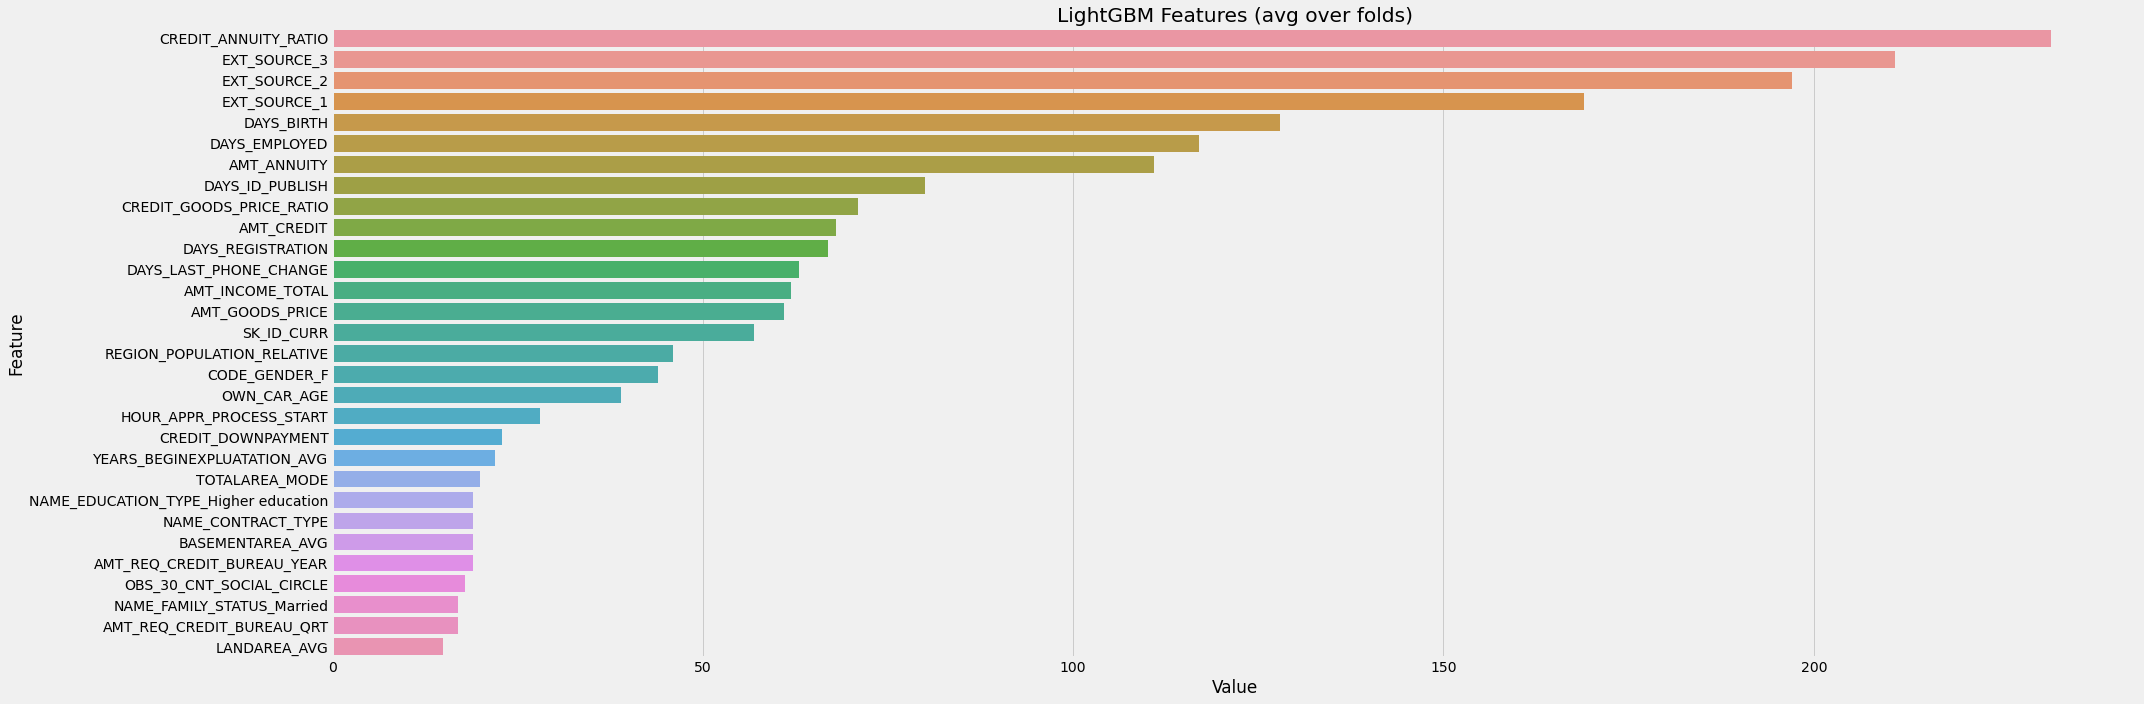

In [135]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def Feature_Interpretability (model, X_train, y_train): 
    model.fit(X_train, y_train) 
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,features)), columns=['Value','Feature'])
    #plt.figure(figsize=(20, 10))

    plt.figure(figsize=(30, 10))
    j=sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30)).get_figure()
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    j.savefig('lgbm_importances-01.jpg')
    
Feature_Interpretability (best_lgbm_cw, X_train, y_train)

### II- Interprétabilité des modèles avec lime

In [121]:
import lime
import lime.lime_tabular

In [122]:
def LIME_Interpretability (model, X_train, y_train, choosen_instance): 
    model.fit(X_train, y_train) 
    
    # Create the Explainer
    ## Create a lambda function for each classifier that will return the predicted probability for the target variable 
    predict_fn_model = lambda x: model.predict_proba(x).astype(float)# ne marche pas sinon

    #predict_fn_rf = lambda x: rfc_cw.predict(x).astype(float) 
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train,feature_names = features, class_names=['Will pay loan', 'Will not pay loan'],kernel_width=5)
    
    # Use the explainer to explain predictions
    exp = explainer.explain_instance(choosen_instance, predict_fn_model,num_features=10)
    exp.show_in_notebook(show_all=False)
    exp.as_pyplot_figure()

In [123]:
choosen_instance = X_test[421]

best_logit_cw = LogisticRegression( C= 0.1 , solver="liblinear", class_weight="balanced")
best_rfc_cw = RandomForestClassifier( criterion= 'entropy', max_depth= 10, n_estimators= 100, class_weight="balanced")
best_dtc_cw = DecisionTreeClassifier( criterion = 'entropy', max_depth= 8, class_weight="balanced")
best_xgb_cw = XGBClassifier(max_depth= 5, min_child_weight= 3, class_weight="balanced")
best_lgbm_cw = LGBMClassifier(boosting_type= 'goss', max_depth = 5, n_estimators= 100, class_weight="balanced" )




Sélectionner XGB Classifier et LGBM Classifier pour l'interprétation d'un résultat. De manière généralesi l'on regarde le reste des modèles, les valeurs de probabilité pour chaque classe sont différentes pour chaque algorithme car les poids des caractéristiques calculés par chaque algorithme sont différents. En fonction de la valeur réelle des caractéristiques d'un enregistrement particulier et des poids attribués à ces caractéristiques, l'algorithme calcule la probabilité de classe, puis prédit la classe ayant la probabilité la plus élevée. 

#### - XG Boost Classifier

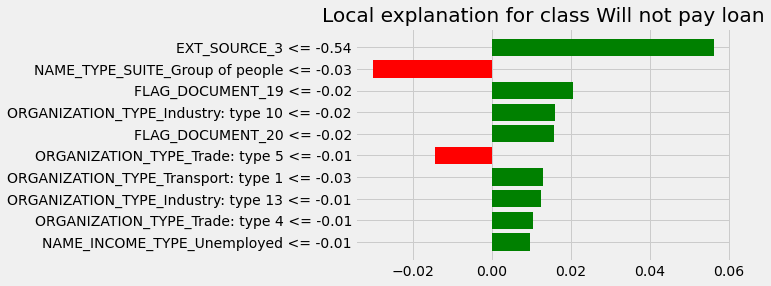

In [125]:
# Get the explanation for XGB Classifier
LIME_Interpretability (best_xgb_cw, X_train, y_train, choosen_instance)

- Le modèle a prédit Will pay loan (va payer). Les six plus grands effets sont ORGANIZATION_TYPE_Religion, EXT_SOURCE_3, EXT_SOURCE_2, NAME_TYPE_SUITE_Group of people, ORGANIZATION_TYPE_Transport: type 1 et ORGANIZATION_TYPE_Trade: type 4. Ils ont considérablement diminuéé ses chances de non payement de crédit. 

- Seul ORGANIZATION_TYPE_Cleaning avec une valeur inférieur -0.03 a augmenté les chances de non payement de crédit.

#### - LGB Classifier

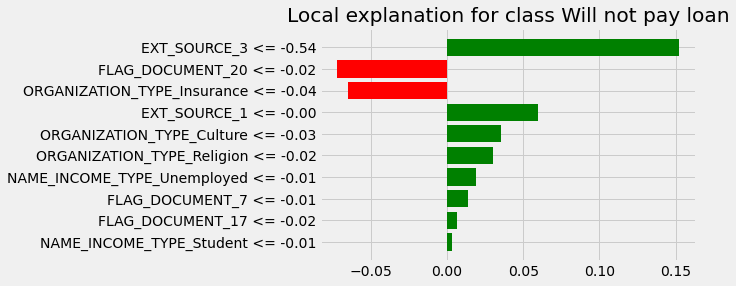

In [126]:
# Get the explanation for LGBM Classifier
LIME_Interpretability (best_lgbm_cw, X_train, y_train, choosen_instance)